## Clean data script
A very quick script to process the data for .  Note that the data are so large and the EPA servers are so inconsistent that even the `requests` module with streaming data fails.  So just download the data to your local machine to process.  The objective is to just get started with some real data for California.

### Download the relevant data from source
Download the data to a temp folder, given how large the raw datasets are and how small the output data are. Starting with PM2.5.  

In [6]:
import os
import requests
import zipfile

In [4]:
# This will take many minutes if not already in the /tmp folder
url_list = [
    (2015, "https://gaftp.epa.gov/EJSCREEN/2015/EJSCREEN_20150505.csv.zip"),
    (2016, "https://gaftp.epa.gov/EJSCREEN/2016/EJSCREEN_V3_USPR_090216_CSV.zip"),
    (2017, "https://gaftp.epa.gov/EJSCREEN/2017/EJSCREEN_2017_USPR_Public.csv"),
    (2018, "https://gaftp.epa.gov/EJSCREEN/2018/EJSCREEN_2018_USPR_csv.zip"),
    (2019, "https://gaftp.epa.gov/EJSCREEN/2019/EJSCREEN_2019_USPR.csv.zip"),
    (2020, "https://gaftp.epa.gov/EJSCREEN/2020/EJSCREEN_2020_USPR.csv.zip")
]

def download_and_process(record, target_dir = "/tmp"):
    """
    Download and process the CSVs from EJSCREEN into a standardized file set
    for each year.
    """
    year, url = record
    urlpath, file_extension = os.path.splitext(url)
    fname = urlpath.split("/")[-1]
    
    # Writing to file
    endgame = "%s/%s" % (target_dir, fname + file_extension)

    if os.path.exists(endgame):
        print("File exists: %s" % endgame)
        if file_extension == ".zip":
            with zipfile.ZipFile(endgame, 'r') as zip_ref:
                [csvname] = zip_ref.namelist()
        else:
            csvname = fname + file_extension
 
    # If the 
    else:
        r = requests.get(url, allow_redirects=True, verify=False)
        with open(endgame, "wb") as f:
            f.write(r.content)

            if file_extension == ".zip":
                with zipfile.ZipFile(endgame, 'r') as zip_ref:
                    zip_ref.extractall(target_dir)
                    [csvname] = zip_ref.namelist()

                    os.rename(
                        target_dir + "/" + csvname, 
                        target_dir + "/%s.csv" % year
                    )
    
    return target_dir + "/%s.csv" % year
    
                    
res = [download_and_process(url) for url in url_list]

File exists: /tmp/EJSCREEN_20150505.csv.zip
File exists: /tmp/EJSCREEN_V3_USPR_090216_CSV.zip
File exists: /tmp/EJSCREEN_2017_USPR_Public.csv
File exists: /tmp/EJSCREEN_2018_USPR_csv.zip
File exists: /tmp/EJSCREEN_2019_USPR.csv.zip
File exists: /tmp/EJSCREEN_2020_USPR.csv.zip


In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd

#### 2015

In [6]:
df = pd.read_csv(
    filepath_or_buffer="/tmp/2015.csv",
    usecols=["statename", "FIPS", "pm", "o3"],
    low_memory=False
)
df = df[df.statename == "California"]
df["year"] = 2015
df.columns = ["id", "ozone", "pm", "statename", "year"]
df[["id", "year", "ozone", "pm"]].to_csv("../data/2015.csv", index=False)

#### 2016-2020

In [7]:
for year in [2016, 2017, 2018, 2019, 2020]:
    df = pd.read_csv(
        filepath_or_buffer="/tmp/%s.csv" % year,
        usecols=["ID", "STATE_NAME", "PM25", "OZONE"],
        low_memory=False
    )
    df = df[df.STATE_NAME == "California"]
    df["year"] = year
    df.columns = ["id", "ozone", "pm", "statename", "year"]
    df[["id", "year", "ozone", "pm"]].to_csv("../data/%s.csv" % year)

### Append the data into a single data frame

In [8]:
res = []

for year in range(2015, 2021):
    df = pd.read_csv(
        filepath_or_buffer="../data/%s.csv" % year,
        na_values="None"
    )
    res.append(df[["id", "year", "ozone", "pm"]])
    
df = pd.concat(res)
df.astype({'pm': 'float', 'ozone': 'float'})
df.to_csv("../data/sample.csv")

/Users/danhammer/streamlitenv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/danhammer/streamlitenv/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


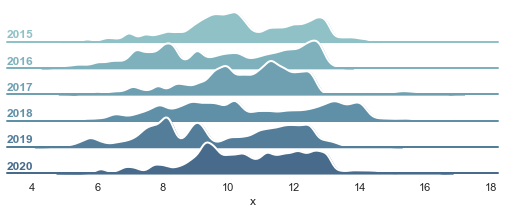

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = pd.read_csv("../data/sample.csv")
df = df[["id", "year", "ozone", "pm"]]
x = df.pm
g = df.year.astype("str")

# Create the data
df = pd.DataFrame(dict(x=x, g=g))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)